In [62]:
import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter('ignore')

In [63]:
import tensorflow as tf

In [64]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime
from datetime import timedelta
from tqdm import tqdm
from GRU_stock_data_processing import *
# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

sns.set()
tf.random.set_seed(1234)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Load Dataset and Select Ticker

In [65]:
stock_df = pd.read_csv("../stock_yfinance_data.csv")
ticker = 'TSLA'
stock_filt = stock_df['Stock Name'] == ticker
df = stock_df[stock_filt]
window = 30
df = clean_stock_data(df, window)
df.head()

,date,open,high,low,close,adj_close,volume,stock_name,moving_max,moving_min,moving_avg_volume,moving_avg_HL
0,2021-09-30,260.333344,263.043335,258.333344,258.493347,258.493347,53868000,TSLA,258.493347,258.493347,53868000.0,4.709991
1,2021-10-01,259.466675,260.260010,254.529999,258.406677,258.406677,51094200,TSLA,258.493347,258.406677,52481100.0,5.220001
2,2021-10-04,265.500000,268.989990,258.706665,260.510010,260.510010,91449900,TSLA,260.510010,258.406677,65470700.0,6.907776
3,2021-10-05,261.600006,265.769989,258.066681,260.196655,260.196655,55297800,TSLA,260.510010,258.406677,62927475.0,7.106659
4,2021-10-06,258.733337,262.220001,257.739990,260.916656,260.916656,43898400,TSLA,260.916656,258.406677,59121660.0,6.581329


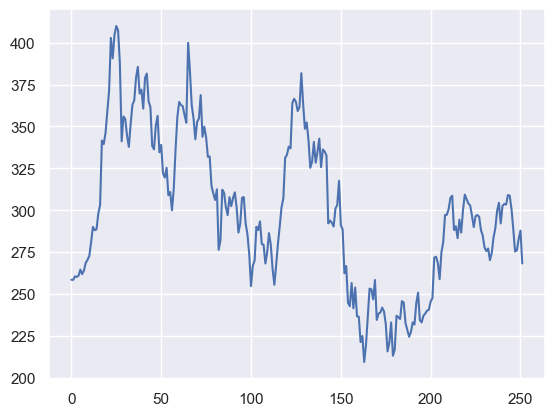

In [66]:
plt.plot(df['close'].values)

### Generate Useful Features

In [67]:
features = gen_features(df)
#only keep window-end samples before full window are invalid
features = features[window:]
features.head()

,target,close,volume,day_HL,sma,ema,rsi,macd_line,macd_signal,macd_histogram,bb_middle,bb_upper,bb_lower
30,-0.415753,1.389737,-0.225144,1.205485,1.225250,1.240823,1.294347,0.337084,0.377391,-0.040307,1.225250,2.329673,0.120826
31,-2.829310,1.274551,-0.123877,0.834094,1.271798,1.244036,1.048356,0.298930,0.361699,-0.062768,1.271798,2.295270,0.248325
32,-1.938224,1.195642,0.185585,1.239311,1.307861,1.239427,1.022191,0.259337,0.341226,-0.081890,1.307861,2.261470,0.354252
33,4.079377,1.361721,-0.103368,1.246601,1.353595,1.251074,1.061015,0.238609,0.320703,-0.082094,1.353595,2.216830,0.490360
34,3.250121,1.494039,0.042524,1.399640,1.405584,1.274213,1.051915,0.230206,0.302603,-0.072398,1.405584,2.159023,0.652145


Text(0.5, 1.0, 'Normalized Closing Price Using Accumulated % Changes')

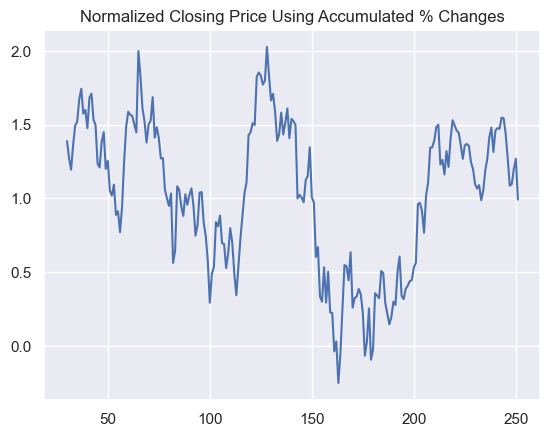

In [68]:
plt.plot(features['close'])
plt.title('Normalized Closing Price Using Accumulated % Changes')

### Generate GRU train and test split

In [69]:
target = 0 #predict closing delta
data = features.to_numpy()
datax, datay = generate_LSTM_data(data, sequence_size=20, target_idx=target, pred_size=3)
print('LSTM Data')
print("> Data X: " + str(datax.shape))
print("> Data y: " + str(datay.shape))
test_size = 30
datax_train = datax[:-test_size]
datay_train = datay[:-test_size]
print('Train Set')
print("> Data X: " + str(datax_train.shape))
print("> Data y: " + str(datay_train.shape))
datax_test = datax[-test_size:]
datay_test = datay[-test_size:]
print('Test Set')
print("> Data X: " + str(datax_test.shape))
print("> Data y: " + str(datay_test.shape))

LSTM Data
> Data X: (199, 20, 13)
> Data y: (199, 3)
Train Set
> Data X: (169, 20, 13)
> Data y: (169, 3)
Test Set
> Data X: (30, 20, 13)
> Data y: (30, 3)


### Define Model

In [70]:
class GRU_Model(tf.keras.Model):
    def __init__(self, num_layers, hidden_dim, output_size, dropout_rate=0.1):
        super(GRU_Model, self).__init__()
        
        self.num_layers = num_layers
        self.hidden_dim = hidden_dim
        self.output_size = output_size

        self.gru_layers = [
            tf.keras.layers.GRU(
                hidden_dim,
                activation='tanh',
                return_sequences=True
            ) for _ in range(num_layers-1)
        ]
        self.last_gru = tf.keras.layers.GRU(
            hidden_dim,
            activation='tanh',
            return_sequences=False
        )
        self.dropout = tf.keras.layers.Dropout(dropout_rate)
        self.dense1 = tf.keras.layers.Dense(hidden_dim//2)
        self.dense2 = tf.keras.layers.Dense(output_size)
    
    def call(self, x):
        for gru_layer in self.gru_layers:
            x = gru_layer(x)
            x = self.dropout(x)
        x = self.last_gru(x)
        x = self.dropout(x)
        x = self.dense1(x)
        x = self.dropout(x)
        x = self.dense2(x)
        return x

### Train Model

In [71]:
mymodel = GRU_Model(num_layers=5, hidden_dim=128, output_size=3, dropout_rate=0.1)
mymodel.compile(optimizer="adam", loss="mean_squared_error")
eval = mymodel.evaluate(datax_train, datay_train)

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 19.0606  


In [72]:
history = mymodel.fit(
    x = datax_train,
    y = datay_train,
    validation_split=0.25,
    epochs=15,
    batch_size=128
)

Epoch 1/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 19.9055 - val_loss: 15.7512
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - loss: 19.8095 - val_loss: 15.8065
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 19.8009 - val_loss: 15.6255
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 19.7382 - val_loss: 15.4891
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - loss: 19.7268 - val_loss: 15.4284
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - loss: 19.6945 - val_loss: 15.4553
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - loss: 19.6325 - val_loss: 15.5373
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - loss: 19.5743 - val_loss: 15.4868
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 19.5179 - val_loss: 15.2441
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 19.4284 - val_loss: 15.0567
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - loss: 19.3224 - val_loss: 14.9948
Epoch 12/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - loss: 19.1844

### Plot Performance

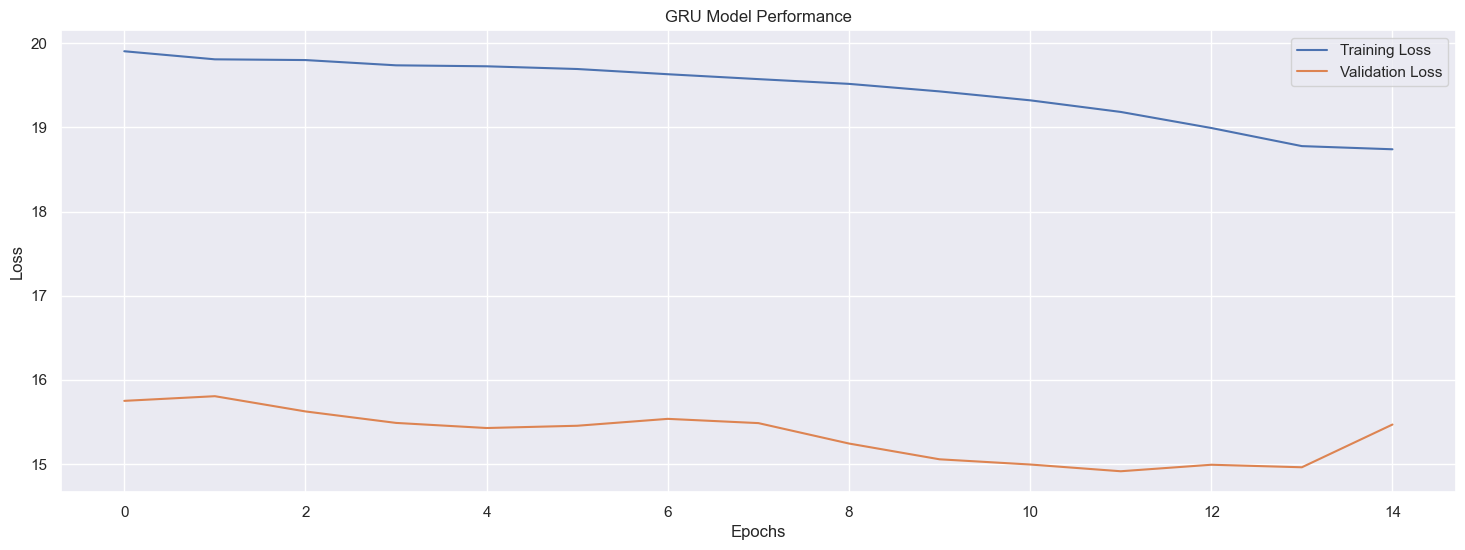

In [73]:
# Visualizing model performance during training
plt.figure(figsize=(18, 6))

plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")

plt.title("GRU Model Performance")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

### 1 Day Advance Prediction

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


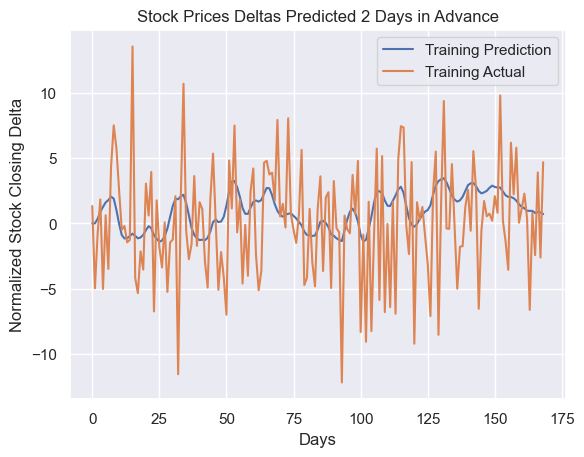

In [74]:
train_predictions = mymodel.predict(datax_train)
train_actual = datay_train
plt.plot(train_predictions[:, 0], label='Training Prediction')
plt.plot(train_actual[:, 0], label='Training Actual')
plt.title('Stock Prices Deltas Predicted 2 Days in Advance')
plt.xlabel('Days')
plt.ylabel('Normalized Stock Closing Delta')
plt.legend()

In [75]:
diff = np.sign(train_predictions[:, 0].flatten())-np.sign(train_actual[:, 0].flatten())
thresh = np.max(np.abs(train_predictions[:, 0]))/2
significant = np.where(np.abs(train_predictions[:, 0].flatten()) > thresh)
print('We perform predictions for ' + str(len(diff)) + ' days')
print('Let a significant day be a day where the absolute value of the predicted closing delta is greater than ' + str(thresh))
print('There are ' + str(len(significant[0])) + ' such events')
print('Of those events, we predict ' + str(np.count_nonzero(diff[significant])) + ' incorrectly')
num_wrong = np.count_nonzero(diff)
err = num_wrong/len(diff)
print('Overall Error Rate: ' + str(err*100) + '%')

We perform predictions for 169 days
Let a significant day be a day where the absolute value of the predicted closing delta is greater than 1.7247182
There are 57 such events
Of those events, we predict 19 incorrectly
Overall Error Rate: 43.19526627218935%


### 2 Day Advance Prediction

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


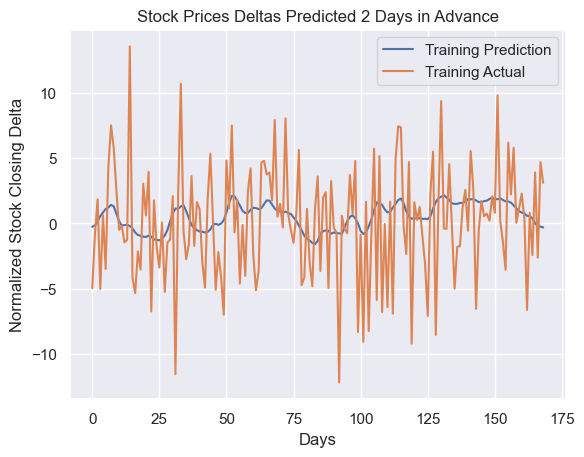

In [76]:
train_predictions = mymodel.predict(datax_train)
train_actual = datay_train
plt.plot(train_predictions[:, 1], label='Training Prediction')
plt.plot(train_actual[:, 1], label='Training Actual')
plt.title('Stock Prices Deltas Predicted 2 Days in Advance')
plt.xlabel('Days')
plt.ylabel('Normalized Stock Closing Delta')
plt.legend()

In [77]:
diff = np.sign(train_predictions[:, 1].flatten())-np.sign(train_actual[:, 1].flatten())
thresh = np.max(np.abs(train_predictions[:, 1]))/2
significant = np.where(np.abs(train_predictions[:, 1].flatten()) > thresh)
print('We perform predictions for ' + str(len(diff)) + ' days')
print('Let a significant day be a day where the absolute value of the predicted closing delta is greater than ' + str(thresh))
print('There are ' + str(len(significant[0])) + ' such events')
print('Of those events, we predict ' + str(np.count_nonzero(diff[significant])) + ' incorrectly')
num_wrong = np.count_nonzero(diff)
err = num_wrong/len(diff)
print('Overall Error Rate: ' + str(err*100) + '%')

We perform predictions for 169 days
Let a significant day be a day where the absolute value of the predicted closing delta is greater than 1.0742903
There are 71 such events
Of those events, we predict 29 incorrectly
Overall Error Rate: 41.42011834319527%


### 3 Day Advance Prediction

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


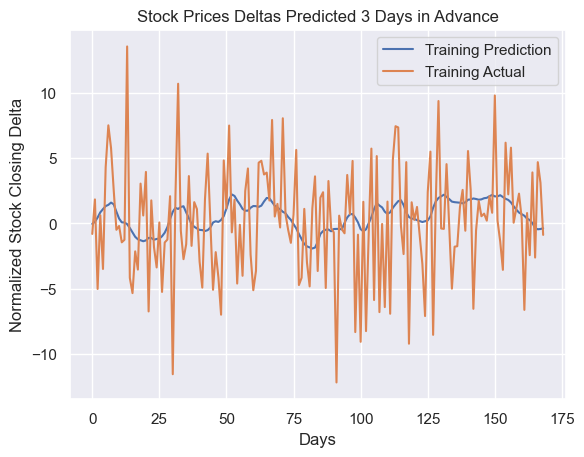

In [78]:
train_predictions = mymodel.predict(datax_train)
train_actual = datay_train
plt.plot(train_predictions[:, 2], label='Training Prediction')
plt.plot(train_actual[:, 2], label='Training Actual')
plt.title('Stock Prices Deltas Predicted 3 Days in Advance')
plt.xlabel('Days')
plt.ylabel('Normalized Stock Closing Delta')
plt.legend()

In [79]:
diff = np.sign(train_predictions[:, 2].flatten())-np.sign(train_actual[:, 2].flatten())
thresh = np.max(np.abs(train_predictions[:, 2]))/2
significant = np.where(np.abs(train_predictions[:, 2].flatten()) > thresh)
print('We perform predictions for ' + str(len(diff)) + ' days')
print('Let a significant day be a day where the absolute value of the predicted closing delta is greater than ' + str(thresh))
print('There are ' + str(len(significant[0])) + ' such events')
print('Of those events, we predict ' + str(np.count_nonzero(diff[significant])) + ' incorrectly')
num_wrong = np.count_nonzero(diff)
err = num_wrong/len(diff)
print('Overall Error Rate: ' + str(err*100) + '%')

We perform predictions for 169 days
Let a significant day be a day where the absolute value of the predicted closing delta is greater than 1.102311
There are 79 such events
Of those events, we predict 32 incorrectly
Overall Error Rate: 44.97041420118343%
